In [1]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# System
import os
import gc
import shutil
import time
import glob

# Main
import random
import numpy as np
import pandas as pd
import json
import cv2
from tqdm import tqdm
tqdm.pandas()
from scipy.io import loadmat

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from IPython.display import Image, display, HTML

In [2]:
if(os.path.exists("datasets")==False):
    os.mkdir("datasets")

if(os.path.exists("datasets/images")==False):
    os.mkdir("datasets/images")
if(os.path.exists("datasets/images/train")==False):
    os.mkdir("datasets/images/train")
if(os.path.exists("datasets/images/val")==False):
    os.mkdir("datasets/images/val")

if(os.path.exists("datasets/labels")==False):
    os.mkdir("datasets/labels")
if(os.path.exists("datasets/labels/train")==False):
    os.mkdir("datasets/labels/train")
if(os.path.exists("datasets/labels/val")==False):
    os.mkdir("datasets/labels/val")

if(os.path.exists("csv_files")==False):
    os.mkdir("csv_files")
if(os.path.exists("sample_videos")==False):
    os.mkdir("sample_videos")
if(os.path.exists("output_videos")==False):
    os.mkdir("output_videos")

In [3]:
debug = False
if(debug):
    train_fol = "3"
    val_fol = "2"
    track_fol = "2"
    epochs =50
else:
    train_fol = ""
    val_fol = ""
    track_fol = ""
    epochs = 50

In [4]:
# Generate Annotations
def convertBoxFormat(box):
    (box_x_left, box_y_top, box_w, box_h) = box
    (image_w, image_h) = (640, 480)
    dw = 1./image_w
    dh = 1./image_h
    x = (box_x_left + box_w / 2.0) * dw
    y = (box_y_top + box_h / 2.0) * dh
    w = box_w * dw
    h = box_h * dh
    return (x, y, w, h)

annotation_dir = '/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/annotations/annotations/*'
classes = ['person']
number_of_truth_boxes = 0

img_id_list = []
label_list = []
split_list = []
num_annot_list = []

# Sets
for sets in tqdm(sorted(glob.glob(annotation_dir))):
    set_id = os.path.basename(sets)
    set_number = int(set_id.replace('set', ''))
    split_dataset = "train" if set_number <=5 else "val"

    # Videos
    for vid_annotations in sorted(glob.glob(sets + "/*.vbb")):
        video_id = os.path.splitext(os.path.basename(vid_annotations))[0] # Video ID
        vbb = loadmat(vid_annotations) # Read VBB File
        obj_lists = vbb['A'][0][0][1][0] # Annotation List
        obj_lbl = [str(v[0]) for v in vbb['A'][0][0][4][0]] # Label List

        # Frames
        for frame_id, obj in enumerate(obj_lists):
            if(len(obj)>0):
                # Labels
                labels = ''
                num_annot = 0
                for pedestrian_id, pedestrian_pos in zip(obj['id'][0], obj['pos'][0]):
                    pedestrian_id = int(pedestrian_id[0][0]) - 1 # Pedestrian ID
                    pedestrian_pos = pedestrian_pos[0].tolist() # Pedestrian BBox
                    # class filter and height filter: here example for medium distance
                    if obj_lbl[pedestrian_id] in classes and pedestrian_pos[3] >= 75 and pedestrian_pos[3] <= 250:
                        yolo_box_format = convertBoxFormat(pedestrian_pos) # Convert BBox to YOLO Format
                        labels += '0 ' + ' '.join([str(n) for n in yolo_box_format]) + '\n'
                        num_annot += 1
                        number_of_truth_boxes += 1

                # Check Labels
                if not labels:
                    continue

                image_id = set_id + '_' + video_id + '_' + f"{frame_id:04d}"
                img_id_list.append(image_id)
                label_list.append(labels)
                split_list.append(split_dataset)
                num_annot_list.append(num_annot)

print("Number of Ground Truth Annotation Box:", number_of_truth_boxes)

df_caltech_annot = pd.DataFrame({
    "image_id": img_id_list,
    "label": label_list,
    "split": split_list,
    "num_annot": num_annot_list
})

df_caltech_annot["set_id"] = df_caltech_annot["image_id"].apply(lambda x: x.split("_")[0])
df_caltech_annot["video_id"] = df_caltech_annot["image_id"].apply(lambda x: x.split("_")[1])
df_caltech_annot["frame_id"] = df_caltech_annot["image_id"].apply(lambda x: int(x.split("_")[2]))

df_caltech_annot.to_csv("csv_files/frame_metadata.csv", index=False)
df_caltech_annot

100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


Number of Ground Truth Annotation Box: 50775


,image_id,label,split,num_annot,set_id,video_id,frame_id
0,set00_V001_0043,0 0.9132596380002878 0.40396814269354026 0.033...,train,1,set00,V001,43
1,set00_V001_0044,0 0.9201749299762035 0.40417785997183425 0.032...,train,1,set00,V001,44
2,set00_V001_0045,0 0.9272476390096147 0.4043875772501283 0.0326...,train,1,set00,V001,45
3,set00_V001_0046,0 0.9336984094848542 0.4093106823792465 0.0327...,train,1,set00,V001,46
4,set00_V001_0047,0 0.9406430902087917 0.41283289921316346 0.032...,train,1,set00,V001,47
...,...,...,...,...,...,...,...
30061,set10_V011_1729,0 0.09544750372975269 0.43736416003599493 0.05...,val,1,set10,V011,1729
30062,set10_V011_1730,0 0.08342295840437615 0.436796882400303 0.0577...,val,1,set10,V011,1730
30063,set10_V011_1731,0 0.07139841307899962 0.43622960476461103 0.05...,val,1,set10,V011,1731
30064,set10_V011_1732,0 0.05937386775362308 0.4356623271289191 0.058...,val,1,set10,V011,1732


In [5]:
df_set_video = df_caltech_annot.groupby(["set_id", "video_id", "split"])["image_id"].count().reset_index()
df_set_video = df_set_video.rename(columns={"image_id": "total_image"})

df_set_video_train = df_set_video[df_set_video["split"]=="train"].reset_index(drop=True)
df_set_video_val = df_set_video[df_set_video["split"]=="val"].reset_index(drop=True)

display(df_set_video_train.head())
display(df_set_video_val.head())

total_train_image = sum(df_set_video_train["total_image"])
total_val_image = sum(df_set_video_val["total_image"])
print("Number of Train:", total_train_image)
print("Number of Val:", total_val_image)

df_set_video_train = df_set_video_train.groupby("set_id")["video_id"].count().reset_index()
df_set_video_val = df_set_video_val.groupby("set_id")["video_id"].count().reset_index()

df_set_video_count = pd.concat([df_set_video_train, df_set_video_val], ignore_index=True)
df_set_video_count = df_set_video_count.rename(columns={"video_id": "total_video"})

display(df_set_video_count)

,set_id,video_id,split,total_image
0,set00,V001,train,539
1,set00,V002,train,408
2,set00,V004,train,137
3,set00,V006,train,1143
4,set00,V007,train,892


,set_id,video_id,split,total_image
0,set06,V000,val,50
1,set06,V001,val,115
2,set06,V002,val,322
3,set06,V003,val,23
4,set06,V005,val,27


Number of Train: 18041
Number of Val: 12025


,set_id,total_video
0,set00,12
1,set01,6
2,set02,3
3,set03,9
4,set04,10
5,set05,12
6,set06,15
7,set07,12
8,set08,5
9,set09,11


In [6]:
df_train_filtered = pd.DataFrame()
df_val_filtered = pd.DataFrame()

set_id_list = list(df_caltech_annot["set_id"].unique())

for i, set_id in enumerate(set_id_list):
    df_set_id = df_set_video[df_set_video["set_id"] == set_id].reset_index(drop=True)
    video_id_list = list(df_set_id["video_id"].unique())

    for j, vid_id in enumerate(video_id_list):
        df_video_id = df_caltech_annot[
            (df_caltech_annot["set_id"] == set_id) &
            (df_caltech_annot["video_id"] == vid_id)
        ].reset_index(drop=True)

        frame_total = df_video_id.shape[0]

        if i <= 5:  # 10000 Train Images
            limit = int(round((frame_total / total_train_image) * 10000, 0))
            df_video_id = df_video_id[:limit]
            df_train_filtered = pd.concat([df_train_filtered, df_video_id], ignore_index=True)

        else:  # 2500 Val Images
            limit = int(round((frame_total / total_val_image) * 2500, 0))
            df_video_id = df_video_id[:limit]
            df_val_filtered = pd.concat([df_val_filtered, df_video_id], ignore_index=True)

df_train_filtered = df_train_filtered.reset_index(drop=True)
df_val_filtered = df_val_filtered.reset_index(drop=True)

display(df_train_filtered)
display(df_val_filtered)

df_train_filtered.to_csv("csv_files/train_frame_filtered.csv", index=False)
df_val_filtered.to_csv("csv_files/val_frame_filtered.csv", index=False)

,image_id,label,split,num_annot,set_id,video_id,frame_id
0,set00_V001_0043,0 0.9132596380002878 0.40396814269354026 0.033...,train,1,set00,V001,43
1,set00_V001_0044,0 0.9201749299762035 0.40417785997183425 0.032...,train,1,set00,V001,44
2,set00_V001_0045,0 0.9272476390096147 0.4043875772501283 0.0326...,train,1,set00,V001,45
3,set00_V001_0046,0 0.9336984094848542 0.4093106823792465 0.0327...,train,1,set00,V001,46
4,set00_V001_0047,0 0.9406430902087917 0.41283289921316346 0.032...,train,1,set00,V001,47
...,...,...,...,...,...,...,...
9995,set05_V012_0463,0 0.6150727153784218 0.44613023349436387 0.068...,train,3,set05,V012,463
9996,set05_V012_0464,0 0.6183738425925924 0.4472574476650563 0.0691...,train,3,set05,V012,464
9997,set05_V012_0465,0 0.6216749698067631 0.4483846618357487 0.0698...,train,3,set05,V012,465
9998,set05_V012_0466,0 0.6249760970209337 0.4495118760064411 0.0704...,train,3,set05,V012,466


,image_id,label,split,num_annot,set_id,video_id,frame_id
0,set06_V000_0272,0 0.12745660746235818 0.45532887301498437 0.05...,val,1,set06,V000,272
1,set06_V000_0273,0 0.12537228551704158 0.4567743326264715 0.052...,val,1,set06,V000,273
2,set06_V000_0274,0 0.12321162631467948 0.4581447419812191 0.053...,val,1,set06,V000,274
3,set06_V000_0275,0 0.1210509671123174 0.4595151513359667 0.0535...,val,1,set06,V000,275
4,set06_V000_0276,0 0.119307780048436 0.45903686683006545 0.0546...,val,1,set06,V000,276
...,...,...,...,...,...,...,...
2493,set10_V011_0360,0 0.9008835022651756 0.4751380896561523 0.0809...,val,2,set10,V011,360
2494,set10_V011_0361,0 0.9032056079724717 0.47521323726753173 0.080...,val,2,set10,V011,361
2495,set10_V011_0362,0 0.905537775587288 0.4752883848789113 0.08045...,val,2,set10,V011,362
2496,set10_V011_0363,0 0.9078800051096245 0.4753635324902908 0.0802...,val,2,set10,V011,363


In [7]:
# https://github.com/simonzachau/caltech-pedestrian-dataset-to-yolo-format-converter
# Generate Images from Video Files
def save_img(dir_path, fn, i, frame):
    cv2.imwrite('{}/{}_{}_{}.png'.format(
        dir_path, os.path.basename(dir_path), os.path.basename(fn).split('.')[0], f"{i:04d}"),
        frame)

def convert_caltech(split, df):
    # Directory Path
    print(split)
    input_dir = "/kaggle/input/caltechpedestriandataset/caltechpedestriandataset"
    output_dir = "datasets/images"
    if(split=="Train"):
        output_dir = os.path.join(output_dir, "train")
    else:
        output_dir = os.path.join(output_dir, "val")
    output_dir = os.path.join(output_dir, "caltechpedestriandataset")
    if(os.path.exists(output_dir)==False):
        os.mkdir(output_dir)

    # Sets
    sets_list = sorted(glob.glob(os.path.join(input_dir, split+"/*")))
    print("Total Sets:", len(sets_list))
    for dname in sets_list:
        print(dname)
        dname2 = dname.split("/")[-1]
        output_dir2 = os.path.join(output_dir, dname2)
        if(os.path.exists(output_dir2)==False):
            os.mkdir(output_dir2)
        df_filtered = df[df["set_id"]==dname2].reset_index(drop=True)

        # Videos
        videos_list = list(df_filtered["video_id"].unique())
        print("Total Videos:", len(videos_list))
        for i, vd in enumerate(videos_list):
            fn = os.path.join(dname, dname2, vd+".seq")
            print(fn)
            cap = cv2.VideoCapture(fn)
            df_filtered2 = df_filtered[df_filtered["video_id"]==vd]

            # Frames
            frame_set = set(df_filtered2["frame_id"].unique())
            limit = len(frame_set)
            print("Total Frames:", limit)
            j = 0
            k = 0
            while True:
                ret, frame = cap.read()
                if(j in frame_set):
                    save_img(output_dir2, fn, j, frame)
                    k += 1
                    if(k==limit):
                        break
                j += 1

In [8]:
convert_caltech("Train", df_train_filtered)

Train
Total Sets: 6
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Train/set00
Total Videos: 12
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Train/set00/set00/V001.seq
Total Frames: 299
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Train/set00/set00/V002.seq
Total Frames: 226
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Train/set00/set00/V004.seq
Total Frames: 76
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Train/set00/set00/V006.seq
Total Frames: 634
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Train/set00/set00/V007.seq
Total Frames: 494
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Train/set00/set00/V008.seq
Total Frames: 425
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Train/set00/set00/V009.seq
Total Frames: 526
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Train/set00/set00/V010.seq
Total Frames: 517
/kaggle/input/ca

In [9]:
convert_caltech("Test", df_val_filtered)

Test
Total Sets: 5
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Test/set06
Total Videos: 15
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Test/set06/set06/V000.seq
Total Frames: 10
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Test/set06/set06/V001.seq
Total Frames: 24
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Test/set06/set06/V002.seq
Total Frames: 67
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Test/set06/set06/V003.seq
Total Frames: 5
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Test/set06/set06/V005.seq
Total Frames: 6
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Test/set06/set06/V006.seq
Total Frames: 2
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Test/set06/set06/V008.seq
Total Frames: 11
/kaggle/input/caltechpedestriandataset/caltechpedestriandataset/Test/set06/set06/V009.seq
Total Frames: 1
/kaggle/input/caltechpedestriandatase

In [10]:
def generate_labels(split, df):
    # Directory Path
    output_dir = "datasets/labels"
    output_dir = os.path.join(output_dir, split, "caltechpedestriandataset")
    if(os.path.exists(output_dir)==False):
        os.mkdir(output_dir)

    set_id_list = list(df["set_id"].unique())
    for set_id in set_id_list:
        output_dir2 = os.path.join(output_dir, set_id)
        if(os.path.exists(output_dir2)==False):
            os.mkdir(output_dir2)
        df_set_id = df[df["set_id"]==set_id].reset_index(drop=True)
        for idx, row in df_set_id.iterrows():
            label_file = open(output_dir2 + "/" + row["image_id"] + ".txt", 'w')
            label_file.write(row["label"])
            label_file.close()

generate_labels("train", df_train_filtered)
generate_labels("val", df_val_filtered)

In [11]:
def convert_yolo_to_coco(bbox):
    x, y, w, h = bbox
    width, height = 640, 480
    x_min, y_min = int((x - w / 2) * width), int((y - h / 2) * height)
    x_max, y_max = int((x + w / 2) * width), int((y + h / 2) * height)
    return [x_min, y_min, x_max, y_max]

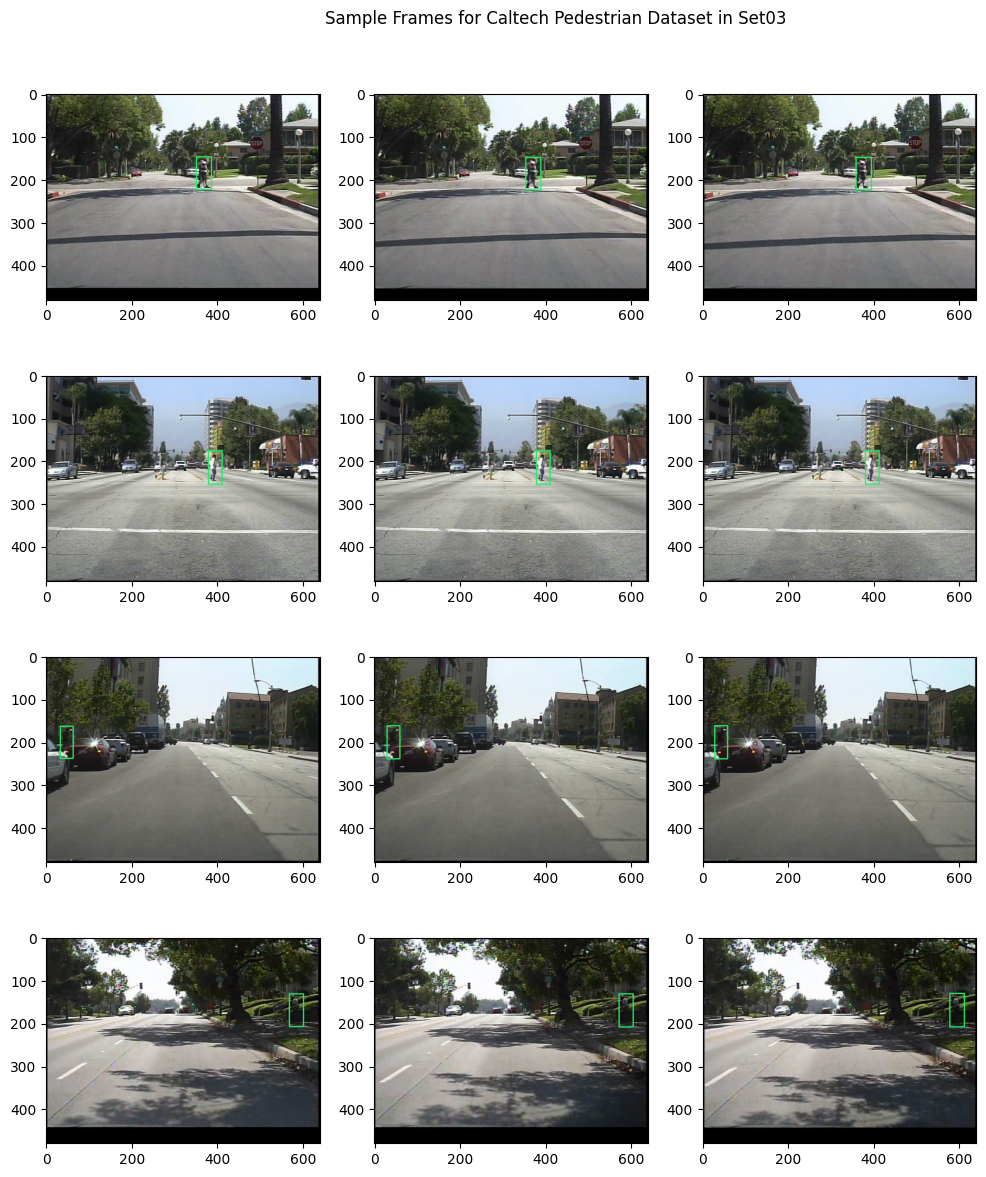

In [12]:
# Sample Frames for Caltech Pedestrian Dataset

# Create Subplots
n_rows = 4
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 14))

# Path
set_name = "set03"
set_image_path = "datasets/images/train/caltechpedestriandataset/{}".format(set_name)
set_label_path = "datasets/labels/train/caltechpedestriandataset/{}".format(set_name)
set_videos = sorted(os.listdir(set_image_path))
list_videos = list(set([x.split("_")[1] for x in set_videos]))
list_videos = sorted(list_videos)[:n_rows]

# Plot the Data
for i, vid_name in enumerate(list_videos):
    list_frames = sorted(glob.glob(set_image_path + "/{}_{}*".format(set_name, vid_name)))[:n_cols]

    for j, frame_path in enumerate(list_frames):
        frame_id = frame_path.split("/")[-1][:-4]

        # Read Image
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Read Text File
        label_frame = open(os.path.join(set_label_path, frame_id + ".txt"),'r').readlines()

        # Bounding Box
        for line in label_frame:
            list_box = [float(x) for x in line[:-1].split(" ")][1:]
            list_box = convert_yolo_to_coco(list_box)
            x1, y1, x2, y2 = list_box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (30, 240, 100), 2)

        # Show Image
        axs[i, j].imshow(frame)
#         axs[i, j].axis("off")

# Title
plt.suptitle("Sample Frames for Caltech Pedestrian Dataset in {}".format(set_name.capitalize()), x=0.55, y=0.93)

# Show
plt.show()

In [13]:
# Get Frame Segments from Set00
set00_frames = sorted(os.listdir("datasets/images/train/caltechpedestriandataset/set00"))
frame_segment = []
frame_segment_list = []
check_segment = False
for i in range(len(set00_frames)):
    num_frame = int(set00_frames[i].split("_")[-1][:4])
    if(check_segment==False or num_frame-1==frame_segment[-1]):
        check_segment = True
        frame_segment.append(num_frame)
    else:
        print(set00_frames[i])
        check_segment = False
        frame_segment_list.append(frame_segment)
        frame_segment = [num_frame]
        if(len(frame_segment_list)==10):
            break

len_frame_segment = [len(x) for x in frame_segment_list]
print(len_frame_segment)

set00_V001_0358.png
set00_V001_0393.png
set00_V001_0500.png
set00_V001_0536.png
set00_V001_0903.png
set00_V002_0108.png
set00_V004_0000.png
set00_V004_0537.png
set00_V004_1067.png
set00_V006_0000.png
[8, 33, 28, 10, 38, 182, 226, 16, 28, 32]


In [14]:
# Convert Frames to Video
def convert_frames2video(frame_list, output):
    # Parameters
    fps = 25.0
    frame_size = (640, 480)

    # Create Video Writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output, fourcc, fps, frame_size)

    # Write frames to video writer
    for frame in frame_list:
        video.write(cv2.imread(frame))

    # Close video writer
    video.release()

    print("The output video is:", output)

In [15]:
# Get Frames from Segment #6
frame_segment_choice = ["datasets/images/train/caltechpedestriandataset/set00/set00_V001_" + f"{x:04d}.png" for x in frame_segment_list[5]]
print(len(frame_segment_choice))
display(frame_segment_choice[:4])

convert_frames2video(frame_segment_choice, "sample_videos/sample_video_1.mp4")

182


['datasets/images/train/caltechpedestriandataset/set00/set00_V001_0903.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0904.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0905.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0906.png']

The output video is: sample_videos/sample_video_1.mp4


In [16]:
!ffmpeg -i sample_videos/sample_video_1.mp4 sample_videos/sample_video_1.webm

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [17]:
HTML("""
    <video width="640" height="480" controls>
      <source src="sample_videos/sample_video_1.webm" type="video/webm">
    </video>
""")

In [18]:
# Get Frames from Segment #7
frame_segment_choice = ["datasets/images/train/caltechpedestriandataset/set00/set00_V002_" + f"{x:04d}.png" for x in frame_segment_list[6]]
print(len(frame_segment_choice))
display(frame_segment_choice[:4])

convert_frames2video(frame_segment_choice, "sample_videos/sample_video_2.mp4")

226


['datasets/images/train/caltechpedestriandataset/set00/set00_V002_0108.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V002_0109.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V002_0110.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V002_0111.png']

The output video is: sample_videos/sample_video_2.mp4


In [19]:
!ffmpeg -i sample_videos/sample_video_2.mp4 sample_videos/sample_video_2.webm

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [20]:
HTML("""
    <video width="640" height="480" controls>
      <source src="sample_videos/sample_video_2.webm" type="video/webm">
    </video>
""")

In [21]:
df_train_metadata = pd.read_csv("csv_files/train_frame_filtered.csv")
df_val_metadata = pd.read_csv("csv_files/val_frame_filtered.csv")

df_train_num_annot = df_train_metadata.groupby("num_annot")["image_id"].count().reset_index()
df_train_num_annot = df_train_num_annot.rename(columns={"image_id": "total_image"})
display(df_train_num_annot)

df_val_num_annot = df_val_metadata.groupby("num_annot")["image_id"].count().reset_index()
df_val_num_annot = df_val_num_annot.rename(columns={"image_id": "total_image"})
display(df_val_num_annot)

,num_annot,total_image
0,1,5800
1,2,2515
2,3,828
3,4,347
4,5,139
5,6,114
6,7,26
7,8,3
8,9,10
9,10,3


,num_annot,total_image
0,1,1598
1,2,773
2,3,118
3,4,9


In [22]:
# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Training", "Validation"),
)

# Vertical Bar Chart
fig.add_trace(
    go.Bar(
        x=df_train_num_annot["num_annot"],
        y=df_train_num_annot["total_image"],
        name="Training",
        marker_color="#9f424d"
    ), row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=df_val_num_annot["num_annot"],
        y=df_val_num_annot["total_image"],
        name="Validation",
        marker_color="#4083d9"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="People Distribution per Frame", title_x=0.5, font_family="Cambria",
    width=950, height=400,
    plot_bgcolor="White",
    showlegend=False,
)

# Show
fig.show(renderer="iframe_connected")

In [23]:
# Create Annot DataFrame
def get_annot_dataframe(df):
    image_id_list = []
    label_list = []
    for i in range(len(df)):
        image_id = df["image_id"][i]
        labels = df["label"][i].split("\n")[:-1]
        for j in range(len(labels)):
            list_box = [float(x) for x in labels[j][:-1].split(" ")][1:]
            list_box = convert_yolo_to_coco(list_box)
            image_id_list.append(image_id)
            label_list.append(list_box)

    df_annot = pd.DataFrame({
        "image_id": image_id_list,
        "label": label_list
    })
    df_annot["x1"] = df_annot["label"].apply(lambda x: x[0])
    df_annot["y1"] = df_annot["label"].apply(lambda x: x[1])
    df_annot["x2"] = df_annot["label"].apply(lambda x: x[2])
    df_annot["y2"] = df_annot["label"].apply(lambda x: x[3])
    df_annot["p_width"] = df_annot["x2"] - df_annot["x1"]
    df_annot["p_height"] = df_annot["y2"] - df_annot["y1"]
    df_annot["area"] = df_annot["p_width"] * df_annot["p_height"]
    df_annot["aspect_ratio"] = df_annot["p_width"] / df_annot["p_height"]
    df_annot = df_annot.drop("label", axis=1)

    return df_annot

df_train_annot = get_annot_dataframe(df_train_metadata)
df_val_annot = get_annot_dataframe(df_val_metadata)

display(df_train_annot)
display(df_val_annot)

,image_id,x1,y1,x2,y2,p_width,p_height,area,aspect_ratio
0,set00_V001_0043,573,156,595,231,22,75,1650,0.293333
1,set00_V001_0044,578,156,599,231,21,75,1575,0.280000
2,set00_V001_0045,582,155,603,232,21,77,1617,0.272727
3,set00_V001_0046,587,155,608,237,21,82,1722,0.256098
4,set00_V001_0047,591,155,612,241,21,86,1806,0.244186
...,...,...,...,...,...,...,...,...,...
19360,set05_V012_0466,508,146,548,254,40,108,4320,0.370370
19361,set05_V012_0466,470,148,511,266,41,118,4838,0.347458
19362,set05_V012_0467,379,146,424,286,45,140,6300,0.321429
19363,set05_V012_0467,511,146,552,256,41,110,4510,0.372727


,image_id,x1,y1,x2,y2,p_width,p_height,area,aspect_ratio
0,set06_V000_0272,64,179,98,257,34,78,2652,0.435897
1,set06_V000_0273,63,180,97,258,34,78,2652,0.435897
2,set06_V000_0274,61,180,95,259,34,79,2686,0.430380
3,set06_V000_0275,60,180,94,260,34,80,2720,0.425000
4,set06_V000_0276,58,179,93,261,35,82,2870,0.426829
...,...,...,...,...,...,...,...,...,...
3529,set10_V011_0362,398,178,439,288,41,110,4510,0.372727
3530,set10_V011_0363,555,166,606,289,51,123,6273,0.414634
3531,set10_V011_0363,398,178,439,289,41,111,4551,0.369369
3532,set10_V011_0364,556,166,608,290,52,124,6448,0.419355


In [24]:
def get_annot_variation_dataframe(df_met, df_annot):
    df_met = df_met[df_met["num_annot"]>1].reset_index(drop=True)
    df_met_image_id = list(df_met["image_id"].unique())
    df_annot = df_annot[df_annot["image_id"].isin(df_met_image_id)].reset_index(drop=True)

    df_annot = df_annot.groupby(["image_id"]).agg({
        "p_width": ["min", "max"],
        "p_height": ["min", "max"],
        "area": ["min", "max"],
        "aspect_ratio": ["min", "max"],
    }).reset_index()
    columns = ['_'.join(col) for col in df_annot.columns]
    df_annot.columns = columns
    df_annot = df_annot.rename(columns={"image_id_": "image_id"})

    df_annot["p_width_range"] = df_annot["p_width_max"] - df_annot["p_width_min"]
    df_annot["p_height_range"] = df_annot["p_height_max"] - df_annot["p_height_min"]
    df_annot["area_range"] = df_annot["area_max"] - df_annot["area_min"]
    df_annot["aspect_ratio_range"] = df_annot["aspect_ratio_max"] - df_annot["aspect_ratio_min"]
    df_annot = df_annot.drop(list(df_annot.columns[1:9]), axis=1)

    return df_annot

df_train_annot_var = get_annot_variation_dataframe(df_train_metadata, df_train_annot)
df_val_annot_var = get_annot_variation_dataframe(df_val_metadata, df_val_annot)
display(df_train_annot_var)
display(df_val_annot_var)

,image_id,p_width_range,p_height_range,area_range,aspect_ratio_range
0,set00_V001_0368,5,9,605,0.030960
1,set00_V001_0369,5,9,601,0.032317
2,set00_V001_0370,10,10,1010,0.094044
3,set00_V001_0371,16,10,1488,0.170163
4,set00_V001_0372,23,9,2074,0.254635
...,...,...,...,...,...
4195,set05_V012_0463,4,33,1860,0.066231
4196,set05_V012_0464,5,32,1824,0.061086
4197,set05_V012_0465,5,31,1925,0.048891
4198,set05_V012_0466,5,30,1890,0.044283


,image_id,p_width_range,p_height_range,area_range,aspect_ratio_range
0,set06_V002_0146,4,9,538,0.016409
1,set06_V002_0147,3,10,488,0.000306
2,set06_V002_0148,2,10,414,0.012838
3,set06_V002_0149,4,11,605,0.008117
4,set06_V002_0150,3,11,531,0.004322
...,...,...,...,...,...
895,set10_V011_0360,11,13,1886,0.050037
896,set10_V011_0361,10,13,1763,0.041907
897,set10_V011_0362,11,13,1886,0.050037
898,set10_V011_0363,10,12,1722,0.045265


In [25]:
# Aspect Plot

# Create Subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Aspect Ratio Distribution", "Aspect Ratio Range Variations"]
)

train_color = "#9f424d"
valid_color = "#4083d9"

# Distributions
fig_distplot = ff.create_distplot(
    [df_train_annot["aspect_ratio"], df_val_annot["aspect_ratio"]],
    ["Training", "Validation"],
    bin_size=.5,
    show_rug=False
)

fig.add_trace(go.Scatter(fig_distplot['data'][2], line=dict(color=train_color, width=2)), row=1, col=1)
fig.add_trace(go.Scatter(fig_distplot['data'][3], line=dict(color=valid_color, width=2)), row=1, col=1)

# Range Variations
fig_distvars = ff.create_distplot(
    [df_train_annot_var["aspect_ratio_range"], df_val_annot_var["aspect_ratio_range"]],
    ["Training", "Validation"],
    bin_size=.5,
    show_rug=False
)

fig.add_trace(go.Scatter(fig_distvars['data'][2], line=dict(color=train_color, width=2)), row=1, col=2)
fig.add_trace(go.Scatter(fig_distvars['data'][3], line=dict(color=valid_color, width=2)), row=1, col=2)

# Update Axes
for i in range(2):
    fig.update_xaxes(linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="<b>Aspect Ratio Plot</b>", title_x=0.5, font_family="Cambria",
    width=950, height=400,
    plot_bgcolor="White",
    showlegend=False,
)

# Show
fig.show(renderer="iframe_connected")

In [26]:
!pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 106.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
import os

os.makedirs("custom_ultralytics/nn/modules", exist_ok=True)
os.makedirs("custom_ultralytics/models", exist_ok=True)


In [28]:
cbam_code = r""
import torch
import torch.nn as nn
import torch.nn.functional as F


class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        maxv, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg, maxv], dim=1)
        return self.sigmoid(self.conv(x))


class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(channels)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x
""

with open("custom_ultralytics/nn/modules/cbam.py", "w") as f:
    f.write(cbam_code)

print("CBAM module created!")


CBAM module created!


In [29]:
import torch
import torch.nn as nn

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.max = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
        )
        self.sigmoid = nn.Sigmoid()
        self.spatial = nn.Conv2d(2, 1, 7, padding=3, bias=False)

    def forward(self, x):
        ca = self.sigmoid(self.fc(self.avg(x)) + self.fc(self.max(x)))
        x = x * ca
        sa = self.sigmoid(
            self.spatial(
                torch.cat([x.mean(1, True), x.max(1, True)[0]], dim=1)
            )
        )
        return x * sa


In [30]:
from ultralytics.nn.tasks import DetectionModel

class YOLO11m_CBAM(DetectionModel):
    def __init__(self, cfg='yolo11m.yaml', ch=3, nc=None, verbose=True):
        super().__init__(cfg, ch, nc, verbose)

        # ✅ self EXISTS HERE
        self.model[2] = nn.Sequential(
            self.model[2],
            CBAM(self.model[2].cv2.conv.out_channels)
        )

        self.model[4] = nn.Sequential(
            self.model[4],
            CBAM(self.model[4].cv2.conv.out_channels)
        )


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [31]:
model = YOLO11m_CBAM()
print("✅ YOLO11m-CBAM model created successfully")



                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

In [32]:
open("custom_ultralytics/__init__.py", "w").close()
open("custom_ultralytics/nn/__init__.py", "w").close()
open("custom_ultralytics/nn/modules/__init__.py", "w").close()
open("custom_ultralytics/models/__init__.py", "w").close()
print("✅ __init__.py files created")


✅ __init__.py files created


In [33]:
cbam_code = """
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(
            self.fc(self.avg_pool(x)) + self.fc(self.max_pool(x))
        )

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = x.mean(dim=1, keepdim=True)
        maxv, _ = x.max(dim=1, keepdim=True)
        x = torch.cat([avg, maxv], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.ca = ChannelAttention(channels)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x
"""

with open("custom_ultralytics/nn/modules/cbam.py", "w") as f:
    f.write(cbam_code)

print("✅ cbam.py rewritten")


✅ cbam.py rewritten


In [34]:
import sys
sys.path.append("/kaggle/working")


In [35]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel


In [36]:
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
        )
        self.sigmoid = nn.Sigmoid()
        self.spatial = nn.Conv2d(2, 1, 7, padding=3, bias=False)

    def forward(self, x):
        ca = self.sigmoid(self.fc(self.avg_pool(x)) + self.fc(self.max_pool(x)))
        x = x * ca
        sa = self.sigmoid(self.spatial(torch.cat([x.mean(1, True), x.max(1, True)[0]], dim=1)))
        return x * sa


In [37]:
class YOLO11m_CBAM(DetectionModel):
    def __init__(self, cfg='yolo11m.yaml', ch=3, nc=None, verbose=True):
        super().__init__(cfg, ch, nc, verbose)
        # Add CBAM to backbone layers
        self.model[2] = nn.Sequential(
            self.model[2],
            CBAM(self.model[2].cv2.conv.out_channels)
        )
        self.model[4] = nn.Sequential(
            self.model[4],
            CBAM(self.model[4].cv2.conv.out_channels)
        )


In [38]:
base = YOLO("yolo11m.pt")  # This creates the variable 'base'


In [39]:
cbam_model = YOLO11m_CBAM()



                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

In [40]:
# 1️⃣ Get base pretrained state dict
base_state_dict = base.model.state_dict()  # base weights

# 2️⃣ Get CBAM model state dict
cbam_state_dict = cbam_model.model.state_dict()

# 3️⃣ Keep only matching keys
pretrained_dict = {k: v for k, v in base_state_dict.items() if k in cbam_state_dict}

# 4️⃣ Update CBAM model
cbam_state_dict.update(pretrained_dict)

# 5️⃣ Load into CBAM model
cbam_model.model.load_state_dict(cbam_state_dict)

print("✅ YOLO11m-CBAM model loaded with pretrained weights successfully!")


✅ YOLO11m-CBAM model loaded with pretrained weights successfully!


In [41]:
from ultralytics import YOLO

model = YOLO("yolo11m.pt")   # YOLO v11 nano model

In [42]:
!ls /kaggle/working


csv_files	    datasets	    output_videos  yolo11m.pt
custom_ultralytics  iframe_figures  sample_videos


In [43]:
%%writefile /kaggle/working/custom_dataset.yaml
# Create Custom Dataset Configuration

path: /kaggle/working/datasets
train: /kaggle/working/datasets/images/train
val: /kaggle/working/datasets/images/val

nc: 1  # number of classes
names:
  0: person


Writing /kaggle/working/custom_dataset.yaml


In [44]:
!wandb disabled
!pip install GPUtil

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [45]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())


True
1


In [46]:
from GPUtil import showUtilization as gpu_usage
import torch
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 10% |  2% |


In [47]:
from ultralytics import YOLO

# Load YOLOv11 Nano model
model = YOLO("yolo11m.pt")

# Train the model
model.train(
    data="/kaggle/working/custom_dataset.yaml",  # Path to your dataset YAML
    epochs=epochs,                               # Number of training epochs
    batch=32,  
    # imgsz=480,
    # Batch size
    verbose=True
)


Ultralytics 8.3.253 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/custom_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78bca63f3210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [48]:
metrics = model.val()  # evaluate model performance on the validation set

Ultralytics 8.3.253 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4157.3±1001.6 MB/s, size: 403.0 KB)
val: Scanning /kaggle/working/datasets/labels/val/caltechpedestriandataset/set06.cache... 2498 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2498/2498 1.2Git/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 157/157 4.8it/s 32.9s0.2ss
                   all       2498       3534      0.794       0.59       0.73      0.432
Speed: 0.6ms preprocess, 10.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /kaggle/working/runs/detect/val


In [49]:
!ls /kaggle/working/runs/detect/train


args.yaml			 results.csv	       val_batch0_labels.jpg
BoxF1_curve.png			 results.png	       val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg      val_batch1_labels.jpg
BoxPR_curve.png			 train_batch12520.jpg  val_batch1_pred.jpg
BoxR_curve.png			 train_batch12521.jpg  val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch12522.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch1.jpg      weights
labels.jpg			 train_batch2.jpg


In [50]:
training_results = pd.read_csv("/kaggle/working/runs/detect/train/results.csv".format(train_fol))
list_column = [col.strip() for col in training_results.columns]
training_results.columns = list_column

training_results

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,470.959,1.59921,1.41884,1.33253,0.57838,0.50268,0.50810,0.25100,1.71550,3.23922,1.57797,0.000665,0.000665,0.000665
1,2,937.436,1.57943,1.29629,1.38843,0.74226,0.64135,0.67558,0.36246,1.68000,1.41013,1.53942,0.001305,0.001305,0.001305
2,3,1401.250,1.48497,1.13813,1.33438,0.71413,0.61998,0.67942,0.36146,1.76250,1.40369,1.59333,0.001919,0.001919,0.001919
3,4,1865.010,1.43172,1.07108,1.29377,0.72417,0.65308,0.66943,0.34891,1.75774,1.34744,1.56159,0.001881,0.001881,0.001881
4,5,2328.850,1.34156,0.96188,1.24379,0.70190,0.67294,0.69272,0.36841,1.77002,1.32562,1.58866,0.001842,0.001842,0.001842
5,6,2792.670,1.26712,0.88733,1.21222,0.71702,0.70048,0.72477,0.38428,1.72187,1.18752,1.57412,0.001802,0.001802,0.001802
6,7,3256.230,1.21563,0.82928,1.18205,0.64988,0.68223,0.66677,0.35526,1.69957,1.41935,1.56536,0.001762,0.001762,0.001762
7,8,3719.710,1.16434,0.77639,1.15634,0.76788,0.68987,0.74157,0.41417,1.66357,1.23338,1.56494,0.001723,0.001723,0.001723
8,9,4183.280,1.12066,0.74310,1.13802,0.76821,0.70147,0.74086,0.41330,1.68272,1.19743,1.58094,0.001683,0.001683,0.001683
9,10,4646.800,1.08415,0.70697,1.11840,0.73542,0.70314,0.70675,0.38278,1.72450,1.30966,1.61070,0.001644,0.001644,0.001644


In [51]:
# Training and Validation Loss

# Create Subplot
fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=["Localization Loss", "Classification Loss", "Distributional Focal Loss"],
)

# Configuration Plot
class PlotCFG:
    marker_size = 6.5
    line_size = 2
    train_color = "#9f424d"
    valid_color = "#4083d9"

loss_list = ["box_loss", "cls_loss", "dfl_loss"]
for i, loss in enumerate(loss_list):
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["train/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.train_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
            name="Training"
        ), row=1, col=i+1
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["val/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=1, col=i+1
    )

# Update Axes
ticklabels = ["Box Loss", "Cls Loss", "DFL Loss"]
for i, ticklabel in enumerate(ticklabels):
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(title=ticklabel, linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="Training and Validation Loss", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=350,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [52]:
# Validation Metrics

# Create Subplot
subplot_titles = ["Precision", "Recall", "mAP50", "mAP50-95"]
fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=subplot_titles,
)

# Configuration Plot
class PlotCFG:
    marker_size = 7
    line_size = 2
    train_color = "#9f424d"
    valid_color = "#4083d9"

metrics = ["precision", "recall", "mAP50", "mAP50-95"]
for i, metric in enumerate(metrics):
    # Plot
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["metrics/{}(B)".format(metric)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=(i//2)+1, col=(i%2)+1
    )

    # Update Axes
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)
    fig.update_yaxes(title=subplot_titles[i], linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)

# Update Layout
fig.update_layout(
    title="Validation Metrics", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=600,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

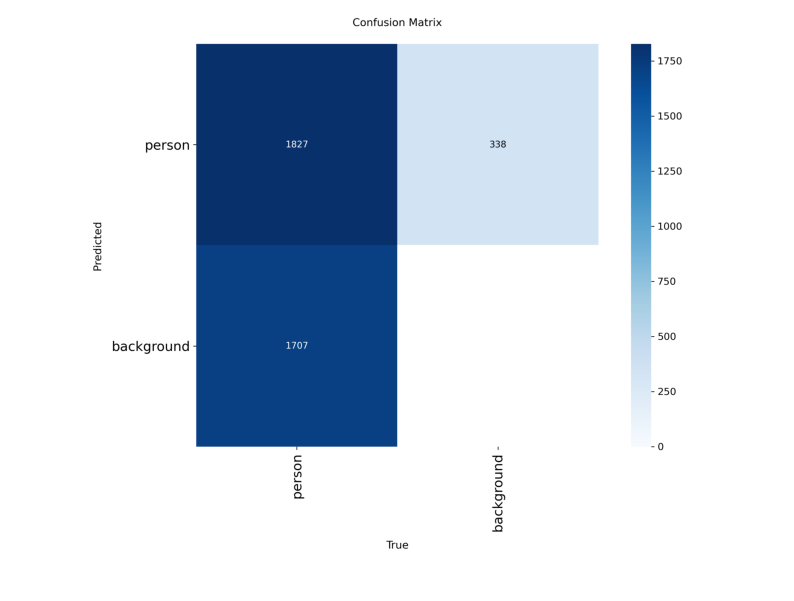

In [53]:
# Confusion Matrix
fig = plt.figure(figsize=(10, 9))
cm_img = mpimg.imread("/kaggle/working/runs/detect/val{}/confusion_matrix.png".format(val_fol))
plt.imshow(cm_img)
plt.axis("off")
fig.show()

In [54]:
!ls /kaggle/working/runs/detect/val/BoxPR_curve.png


/kaggle/working/runs/detect/val/BoxPR_curve.png


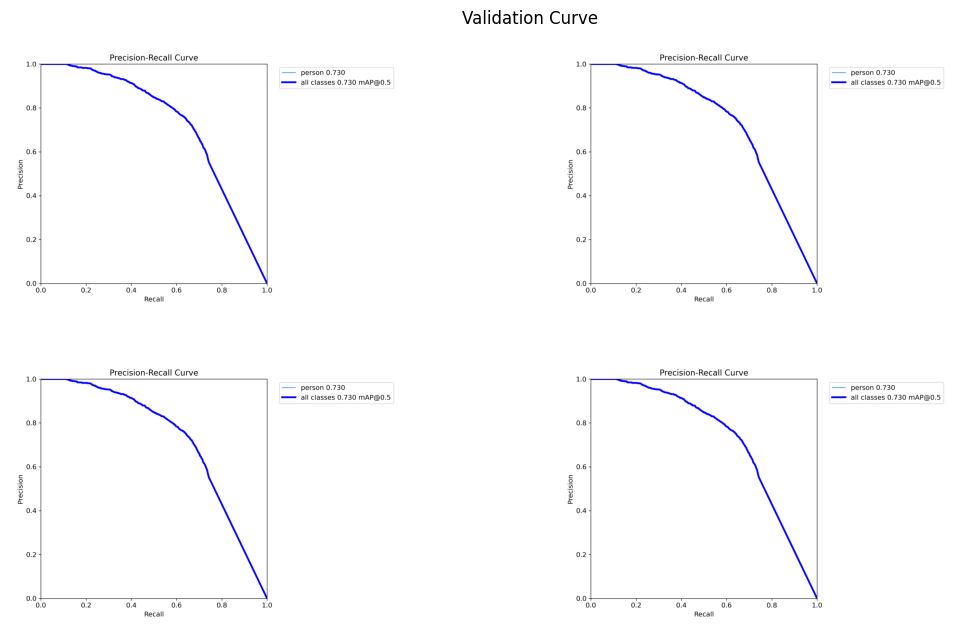

In [55]:
# Validation Curve
fig, axs = plt.subplots(2, 2, figsize=(13, 7.5))
curve_list = ["P_curve", "R_curve", "F1_curve", "PR_curve"]
for i, curve in enumerate(curve_list):
    curve_path = "/kaggle/working/runs/detect/val/BoxPR_curve.png".format(val_fol, curve)
    curve_img = mpimg.imread(curve_path)
    axs[i//2, i%2].imshow(curve_img)
    axs[i//2, i%2].axis('off')

# Title
plt.suptitle("Validation Curve", x=0.55, y=0.93)

# Show
plt.show()

In [56]:
# Get Frames from Segment #6
frame_segment_choice = ["datasets/images/train/caltechpedestriandataset/set00/set00_V001_" + f"{x:04d}.png" for x in frame_segment_list[5]]
print(len(frame_segment_choice))
display(frame_segment_choice[:4])

182


['datasets/images/train/caltechpedestriandataset/set00/set00_V001_0903.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0904.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0905.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0906.png']

In [57]:
def detect_people(frame_list):
    yolo_model = YOLO('/kaggle/working/runs/detect/train{}/weights/best.pt'.format(train_fol))
    bbox_results = yolo_model.predict(frame_list, verbose=False)
    all_box_list = []
    all_conf_list = []
    for bbox_result in bbox_results:
        boxes = bbox_result.boxes
        box_list = []
        conf_list = []
        for box in boxes:
            box_data = box.data[0][:4]
            box_data = [int(x) for x in box_data]
            conf = round(float(box.conf), 2)
            if(conf>=0.5):
                box_list.append(box_data)
                conf_list.append(conf)

        all_box_list.append(box_list)
        all_conf_list.append(conf_list)

    box_results = pd.DataFrame({
        "box_list": all_box_list,
        "conf_list": all_conf_list
    })
    return box_results

out_box_results = detect_people(frame_segment_choice)

In [58]:
def show_people_detection(frame_list, box_results, output):
    # Parameters
    fps = 20.0
    frame_size = (640, 480)

    # Create Video Writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output, fourcc, fps, frame_size)

    # Write Frames to Video Writer
    for i, frame_path in enumerate(frame_list):
        # Read Frame
        frame = cv2.imread(frame_path)

        box_list = box_results.loc[i, "box_list"]
        conf_list = box_results.loc[i, "conf_list"]
        if(len(box_list)>0):
            # For Each Box
            for j, box in enumerate(box_list):
                # Get Bounding Box
                x1, y1, x2, y2 = box

                # Draw Bounding Box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (30, 240, 100), 2)
                cv2.rectangle(frame, (x1-10, y1-25), (x2+10, y1), (30, 240, 100), -1)

                # Create Text Align for Confidence Score
                font = cv2.FONT_HERSHEY_SIMPLEX
                text = 'Conf: ' + str(conf_list[j])

                textsize = cv2.getTextSize(text, font, 0.5, 2)[0]
                textX = ((x2 - x1 + 20) - textsize[0]) // 2
                textY = (25 + textsize[1]) // 2

                # Assign Confidence Score to Frame
                cv2.putText(frame, text, (x1 - 10 + textX, y1 - 25 + textY), font, 0.5, (0, 0, 0), 2)

        video.write(frame)

    # Close video writer
    video.release()

show_people_detection(frame_segment_choice, out_box_results, "output_videos/output_video_detect_1.mp4")

In [59]:
!ffmpeg -i output_videos/output_video_detect_1.mp4 output_videos/output_video_detect_1.webm

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [60]:
HTML("""
    <video width="640" height="480" controls>
      <source src="output_videos/output_video_detect_1.webm" type="video/webm">
    </video>
""")